In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import math
#import random
#import time


/home/matti/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
# volume sfere / volume cubo tot
C = np.pi*4.0/3.0
interf = 3
n=64

def vol_ratio(R):
    return n*C*R**3 / (dim**3)

# volume n sfere a R_max / volume cubo tot
def max_vol_ratio(L):
    rmax = L/(2*np.cbrt(n)) - interf
    return n*C*rmax**3 / (L**3)

# questo e' per vedere un singolo caso: come varia il volume ratio cambiando il raggio delle sfere?
dim=512
Rmax=dim/(2*np.cbrt(n))-interf
start = 20
end = 80
r = np.linspace(start,end,1000)
_ = plt.figure(1)
_ = plt.plot(r,vol_ratio(r),"blue")
_ = plt.hlines(vol_ratio(Rmax), start, end, "red", "--")
_ = plt.vlines(Rmax, 0, 1, "green", "--")
_ = plt.xlabel(r"$R_{droplets}$")
_ = plt.ylabel(r"$V_{droplets}/V_{tot}$")
_ = plt.grid()
_ = plt.ylim([0,1.0])
_ = plt.title(r"$L_{cube}=$%d, $n_{droplets}$=%d"%(dim,n))

# questo invece mostra il max volume ratio (da R_max) per ogni possibile L_cube
start = 256
end = 4096
dims = np.linspace(start,end,1000)
_ = plt.figure(2)
_ = plt.plot(dims,max_vol_ratio(dims), "blue")
_ = plt.xlabel(r"$L_{cube}$")
_ = plt.ylabel(r"$V_{droplets}(R_{max})/V_{tot}$")
_ = plt.grid()
_ = plt.ylim([0.3,0.6])

In [31]:
direc = "/home/matti/DATA/Mayonese/staggered_run/"
dt = 500
start_move = 30000

name  = "output.csv"
head  = np.genfromtxt(direc+name, delimiter=',\t', dtype=str,   max_rows=1)
A     = np.genfromtxt(direc+name, delimiter=',\t', dtype=float, skip_header=True)
ps    = np.unique(A[:, 3])
print(f" header = {head}")
print(f" pushing factor = {ps}")


name  = "avgz.out"
avgz  = np.loadtxt(direc+name)
first_out_shear = int(start_move / dt)
number_out = int(A[-1,0]/dt)
number_lines = 5;
RR = np.linspace(first_out_shear,number_out-1,number_lines).astype(int)
print(RR)

# primo e secondo elemento: step e number_droplets
# terzo e quarto elemento: avarage volume e total volume (ask girotto) ???
# il resto sono vol e surf delle droplets
def read_nonunif_col(f):
    first_two_columns = []
    second_two_columns = []
    matrix_data = []
    with open(f, 'r') as file:
        for line in file:
            elements = line.split()
            first_two_columns.append([int(elements[0]), int(elements[1])])
            second_two_columns.append([float(elements[2]), float(elements[3])]) 
            data = list(map(float, elements[4:]))
            matrix_data.append(data)
    max_length = max(len(row) for row in matrix_data)
    matrix_data_padded = np.array([row + [np.nan] * (max_length - len(row)) for row in matrix_data])
    return np.array(first_two_columns).T, matrix_data_padded, np.array(second_two_columns).T
def binning(d, info, b, rr):
    max_drop_idx = np.argmax(info[1,:])
    max_d = max(d[max_drop_idx,:])+1
    min_d = min(d[max_drop_idx,:])-1
    bins = np.logspace(np.log10(min_d), np.log10(max_d), num=b)
    all_count = []; all_bin_edges = []
    for i in rr:
        count, bin_edges = np.histogram(d[i,:], bins=bins)
        all_count.append(count); all_bin_edges.append(bin_edges)
    return np.array(all_count), np.array(all_bin_edges)
name = "droplets_volume_clean.dat"
step_e_num, d_vol, avg_e_tot_vol = read_nonunif_col(direc+name)
name = "droplets_surface_clean.dat"
step_e_num, d_sur, avg_e_tot_vol = read_nonunif_col(direc+name)
B = 30
#number_lines_b = 8;
#RRb = np.linspace(first_out_shear+1,number_out-1,number_lines_b).astype(int)
count_vol, bin_edges_vol = binning(d_vol, step_e_num, B, RR)
count_sur, bin_edges_sur = binning(d_sur, step_e_num, B, RR)

 header = ['Step' 'N_Drop' 'Vd/Vt' 'Push']
 pushing factor = [0.e+00 2.e-05 1.e-04]
[ 60 111 162 213 264]


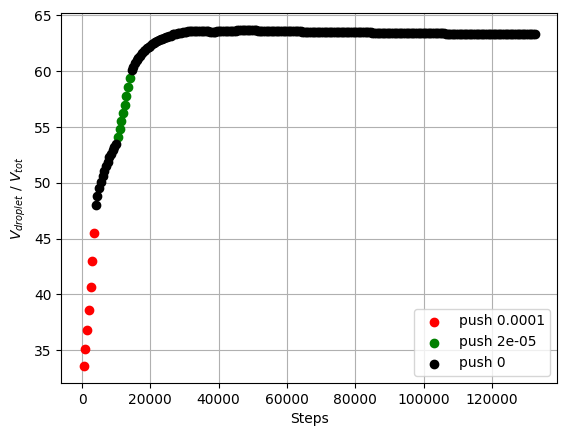

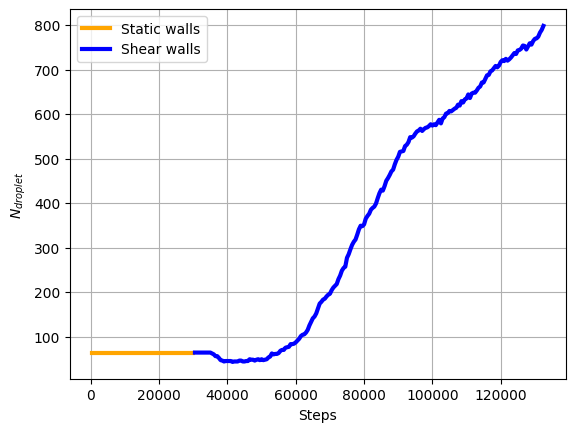

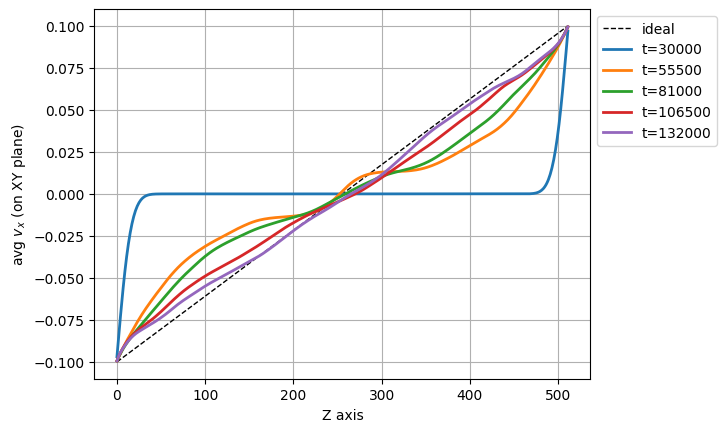

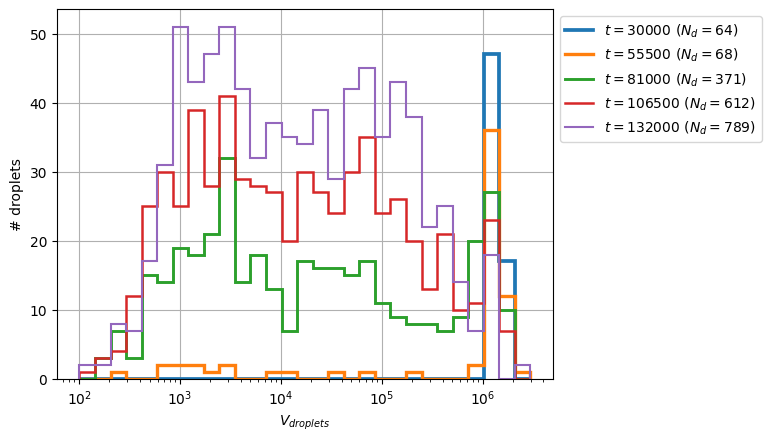

In [35]:
def pp(f, p, col):
    mask = (f[:,3] == p)
    _ = plt.scatter(f[mask,0], f[mask,2], color=col, label='push %1.1g'%(p))
_ = plt.figure(3)
pp(A, ps[2], "red")
pp(A, ps[1], "green")
pp(A, ps[0], "black")
_ = plt.legend()
_ = plt.rc('axes', axisbelow=True)
_ = plt.grid()
_ = plt.xlabel("Steps")
_ = plt.ylabel("$V_{droplet}$ / $V_{tot}$")


def ppN(f, start, stop, name, col):
    mask = ( (f[:,0]<=stop) & (f[:,0]>start) )
    _ = plt.plot(f[mask,0], f[mask,1], color=col, linewidth=3, label=name)
_ = plt.figure(4)
end = A[-1,0]
ppN(A, 0, start_move, "Static walls", "orange")
ppN(A, start_move, end, "Shear walls", "blue")
_ = plt.legend()
_ = plt.rc('axes', axisbelow=True)
_ = plt.grid()
_ = plt.xlabel("Steps")
_ = plt.ylabel("$N_{droplet}$")


_ = plt.figure(5)
l = np.linspace(0,511,10)
lv = np.linspace(-0.1,+0.1,10)
_ = plt.plot(l,lv,color='black', linestyle='--',linewidth=1, label="ideal")
for i in RR:
    _ = plt.plot(avgz[i,:], linewidth=2, label="t=%d"%(i*dt))
_ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
_ = plt.rc('axes', axisbelow=True)
_ = plt.grid()
_ = plt.xlabel("Z axis")
_ = plt.ylabel("avg $v_x$ (on XY plane)")


_ = plt.figure(6)
lw = 3
for i in range(number_lines):
    idx = RR[i]-1 #-1 perche' RR e' pensato per non partire da zero, ma qui ho lo zero
    lw -= 0.3
    _ = plt.stairs(count_vol[i,:], bin_edges_vol[i,:], linewidth=lw, label="$t=%d$ $(N_{d}=%d)$"%(step_e_num[0,idx],step_e_num[1,idx]))
_ = plt.xscale('log')
_ = plt.xlabel('$V_{droplets}$')
_ = plt.ylabel('# droplets')
_ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
_ = plt.grid(True)